<a href="https://colab.research.google.com/github/susanemiliaw/NTHU_2025_DLIA_HW/blob/main/Attempt1_ResNet18_NEW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div align="center">

#### Lab 3

# National Tsing Hua University

#### Spring 2025

#### 11320IEEM 513600

#### Deep Learning and Industrial Applications
    
## Lab 3: Anomaly Detection in Industrial Applications

</div>

### Introduction

In today's industrial landscape, the ability to detect anomalies in manufacturing processes and products is critical for maintaining quality, efficiency, and safety. This lab focuses on leveraging deep learning techniques for anomaly detection in various industrial applications, using the MVTEC Anomaly Detection Dataset. By employing ImageNet-pretrained models available in torchvision, students will gain hands-on experience in classfying defects and irregularities across different types of industrial products.

Throughout this lab, you'll be involved in the following key activities:
- Explore and process the MVTec Anomaly Detection Dataset.
- Apply ImageNet-pretrained models from [Torchvision](https://pytorch.org/vision/stable/models.html) to detect anomalies in industrial products.
- Evaluate the performance of the models to understand their effectiveness in real-world industrial applications.

### Objectives

- Understand the principles of anomaly detection in the context of industrial applications.
- Learn how to implement and utilize ImageNet-pretrained models for detecting anomalies.
- Analyze and interpret the results of the anomaly detection models to assess their practicality in industrial settings.

### Dataset

The MVTec AD Dataset is a comprehensive collection of high-resolution images across different categories of industrial products, such as bottles, cables, and metal nuts, each with various types of defects. This dataset is pivotal for developing and benchmarking anomaly detection algorithms. You can download our lab's dataset [here](https://drive.google.com/file/d/19600hUOpx0hl78TdpdH0oyy-gGTk_F_o/view?usp=share_link). You can drop downloaded data and drop to colab, or you can put into yor google drive.

### References
- [MVTec AD Dataset](https://www.kaggle.com/datasets/ipythonx/mvtec-ad/data) for the dataset used in this lab.
- [Torchvision Models](https://pytorch.org/vision/stable/models.html) for accessing ImageNet-pretrained models to be used in anomaly detection tasks.
- [State-of-the-Art Anomaly Detection on MVTec AD](https://paperswithcode.com/sota/anomaly-detection-on-mvtec-ad) for insights into the latest benchmarks and methodologies in anomaly detection applied to the MVTec AD dataset.
- [CVPR 2019: MVTec AD — A Comprehensive Real-World Dataset for Unsupervised Anomaly Detection] for the original paper of MVTec AD dataset.

In [ ]:
import glob
import matplotlib.pyplot as plt
import random
from tqdm.auto import tqdm
import cv2
import numpy as np
import os

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Set the category to extract (e.g., bottle, cable, etc.)
category = "bottle"
image_path = f"/content/drive/MyDrive/Colab Notebooks/{category}"

# Define root paths
drive_root = "/content/drive/MyDrive/Colab Notebooks/bottle"
train_dir = os.path.join(drive_root, "train")
test_dir = os.path.join(drive_root, "test")

# Get train and test image paths
train_images = glob.glob(f"{train_dir}/good/*.png")
test_images = glob.glob(f"{test_dir}/**/*.png", recursive=True)

# Count classes (excluding 'good')
defect_classes = [d for d in os.listdir(test_dir) if d != 'good']
num_defect_classes = len(defect_classes)

# Example image to get dimensions
sample_img = cv2.imread(train_images[0])
height, width, channels = sample_img.shape

# Output
print("📊 Dataset Summary for 'bottle':")
print(f"• Number of defect classes: {num_defect_classes}")
print(f"• Types of defect classes: {defect_classes}")
print(f"• Total images used: {len(train_images) + len(test_images)}")
print(f"    - Training images (only 'good'): {len(train_images)}")
print(f"    - Test images (good + defective): {len(test_images)}")
print(f"• Image dimensions: {width} x {height} x {channels}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
📊 Dataset Summary for 'bottle':
• Number of defect classes: 3
• Types of defect classes: ['broken_small', 'broken_large', 'contamination']
• Total images used: 292
    - Training images (only 'good'): 209
    - Test images (good + defective): 83
• Image dimensions: 900 x 900 x 3


In [ ]:
file_paths = glob.glob("/content/drive/MyDrive/Colab Notebooks/bottle/**/*/*.png", recursive=True)

In [ ]:
all_data = []

for img in tqdm(file_paths):
    img = cv2.imread(img)
    img = img[..., ::-1]
    all_data.append(img)

all_data = np.stack(all_data)
print(all_data.shape)

  0%|          | 0/355 [00:00<?, ?it/s]

(355, 900, 900, 3)


Classes: ['broken_large', 'broken_small', 'contamination', 'good']


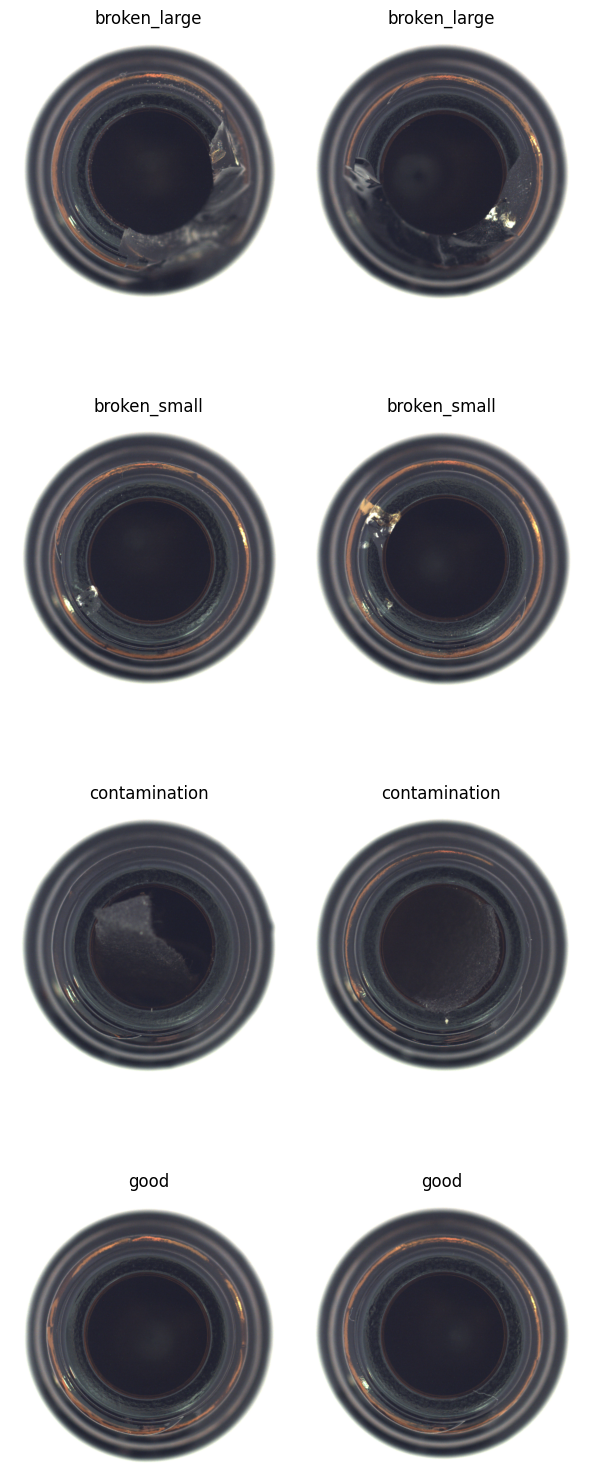

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Define your test directory
test_dir = "/content/drive/MyDrive/Colab Notebooks/bottle/test"

# Get class names from the test folder (e.g., good, broken_large, etc.)
classes = sorted([d for d in os.listdir(test_dir) if os.path.isdir(os.path.join(test_dir, d))])
print(f'Classes: {classes}')

# Show 2 images from each class
fig, axs = plt.subplots(len(classes), 2, figsize=(6, 4 * len(classes)))

for i, class_name in enumerate(classes):
    class_folder = os.path.join(test_dir, class_name)
    images = sorted(glob.glob(f"{class_folder}/*.png"))[:2]  # get first 2 images

    for j, img_path in enumerate(images):
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axs[i, j].imshow(img)
        axs[i, j].axis('off')
        axs[i, j].set_title(f'{class_name}')

plt.tight_layout()
plt.show()

## A. Data Loading and Preprocessing

In [ ]:
import torch
from torch.utils.data import DataLoader, TensorDataset, random_split
import numpy as np
from sklearn.model_selection import train_test_split

# Paths
train_dir = "/content/drive/MyDrive/Colab Notebooks/bottle/train/good"
test_dir = "/content/drive/MyDrive/Colab Notebooks/bottle/test"

# NEW: Load training data with both "good" and some defect images
train_x = []
train_y = []

# Good training images (label 0)
good_train = glob.glob("/content/drive/MyDrive/Colab Notebooks/bottle/train/good/*.png")
for path in good_train:
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    train_x.append(img)
    train_y.append(0)

# Defect images from test folder (label 1)
defect_classes = ['broken_large', 'broken_small', 'contamination']
for cls in defect_classes:
    defect_imgs = sorted(glob.glob(f"/content/drive/MyDrive/Colab Notebooks/bottle/test/{cls}/*.png"))[:10]  # pick 10 from each
    for path in defect_imgs:
        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        train_x.append(img)
        train_y.append(1)

# Convert to NumPy
x_train = np.transpose(np.array(train_x), (0, 3, 1, 2))  # (N, C, H, W)
y_train = np.array(train_y)

print("✅ New training label counts:", np.bincount(y_train))
y_val = np.array(y_val, dtype=np.int64)

print(f'x_train: {x_train.shape}, y_train: {y_train.shape}')
print(f'x_val: {x_val.shape}, y_val: {y_val.shape}')

✅ New training label counts: [209  30]
x_train: (239, 3, 900, 900), y_train: (239,)
x_val: (83, 3, 900, 900), y_val: (83,)


In [ ]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image

train_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.AutoAugment(),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]
)

val_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ]
)

class MyDataset(Dataset):
    def __init__(self, x, y, transform=None):
        self.x = x
        self.y = torch.from_numpy(y).long()
        self.transform = transform

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        new_x = np.transpose(self.x[idx], (1, 2, 0))
        return self.transform(Image.fromarray(new_x)), self.y[idx]

In [ ]:
batch_size = 32

train_dataset = MyDataset(x_train, y_train, transform=train_transforms)
val_dataset = MyDataset(x_val, y_val, transform=val_transforms)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


## B. Defining Neural Networks

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

# Load pretrained ResNet18
model = models.resnet18(weights='IMAGENET1K_V1')

# Freeze all layers (we're only fine-tuning the final FC layer)
for param in model.parameters():
    param.requires_grad = False

# Replace the final fully connected layer to match our binary classification
num_ftrs = model.fc.in_features
num_classes = 2  # good vs defect
model.fc = nn.Linear(num_ftrs, num_classes)

print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## C. Training the Neural Network

In [ ]:
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from tqdm.auto import tqdm

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

epochs = 50
model = model.cuda()

best_val_loss = float('inf')
best_val_acc = -1

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=1e-3)
lr_scheduler = CosineAnnealingLR(optimizer, T_max=len(train_loader)*epochs, eta_min=0)

for epoch in tqdm(range(epochs)):
    model.train()
    total_loss = 0.0
    train_correct = 0
    total_train_samples = 0

    for images, labels in train_loader:
        images, labels = images.cuda(), labels.cuda()

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        train_predicted = outputs.argmax(-1)
        train_correct += (train_predicted == labels).sum().item()
        total_train_samples += labels.size(0)

    avg_train_loss = total_loss / len(train_loader)
    train_accuracy = 100. * train_correct / total_train_samples

    # Validation
    model.eval()
    total_val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.cuda(), labels.cuda()
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_val_loss += loss.item()

            predicted = outputs.argmax(-1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    avg_val_loss = total_val_loss / len(val_loader)
    val_accuracy = 100. * correct / total

    lr_scheduler.step()

    # Save best model
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss

    if val_accuracy > best_val_acc:
        best_val_acc = val_accuracy
        torch.save(model.state_dict(), 'model_classification.pth')

    print(f'Epoch {epoch+1}/{epochs}, Train loss: {avg_train_loss:.4f}, Train acc: {train_accuracy:.2f}%, Val loss: {avg_val_loss:.4f}, Val acc: {val_accuracy:.2f}%, Best Val acc: {best_val_acc:.2f}%')

    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/50, Train loss: 0.4618, Train acc: 81.59%, Val loss: 2.3299, Val acc: 24.10%, Best Val acc: 24.10%
Epoch 2/50, Train loss: 0.3775, Train acc: 87.45%, Val loss: 1.1461, Val acc: 24.10%, Best Val acc: 24.10%
Epoch 3/50, Train loss: 0.3665, Train acc: 87.45%, Val loss: 1.2083, Val acc: 25.30%, Best Val acc: 25.30%
Epoch 4/50, Train loss: 0.3143, Train acc: 87.45%, Val loss: 1.0208, Val acc: 28.92%, Best Val acc: 28.92%
Epoch 5/50, Train loss: 0.2904, Train acc: 87.87%, Val loss: 0.8857, Val acc: 39.76%, Best Val acc: 39.76%
Epoch 6/50, Train loss: 0.2810, Train acc: 89.12%, Val loss: 0.8322, Val acc: 42.17%, Best Val acc: 42.17%
Epoch 7/50, Train loss: 0.2354, Train acc: 91.63%, Val loss: 0.8083, Val acc: 49.40%, Best Val acc: 49.40%
Epoch 8/50, Train loss: 0.2259, Train acc: 90.38%, Val loss: 0.8463, Val acc: 49.40%, Best Val acc: 49.40%
Epoch 9/50, Train loss: 0.2398, Train acc: 90.79%, Val loss: 0.6852, Val acc: 60.24%, Best Val acc: 60.24%
Epoch 10/50, Train loss: 0.2147, Trai

### Visualizing model performance

In [ ]:
print("Train label counts:", np.bincount(y_train))
print("Val label counts:", np.bincount(y_val))


Train label counts: [209  30]
Val label counts: [20 63]


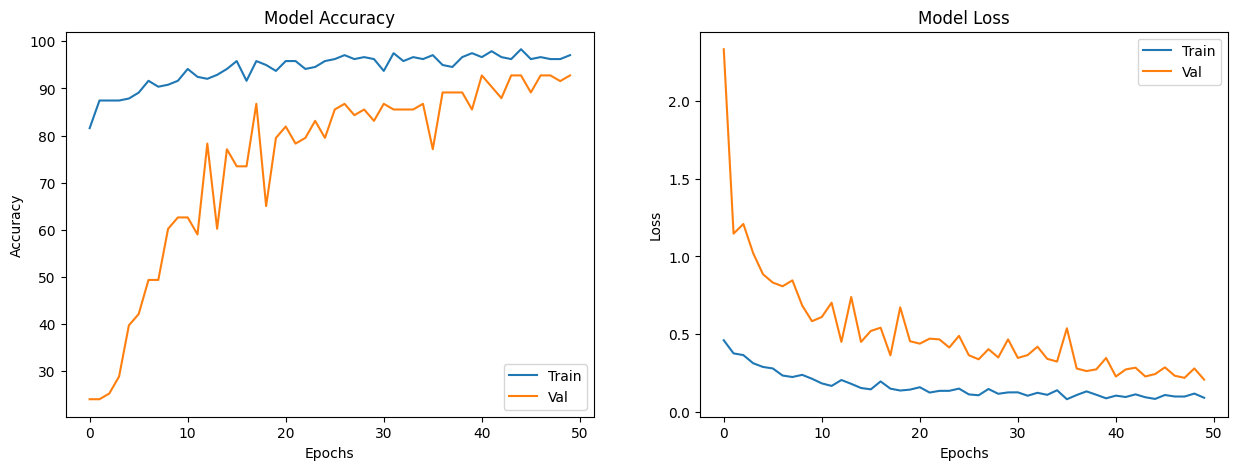

(0.0, 100.0)

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Plotting training and validation accuracy
ax[0].plot(train_accuracies)
ax[0].plot(val_accuracies)
ax[0].set_title('Model Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(['Train', 'Val'])

# Plotting training and validation loss
ax[1].plot(train_losses)
ax[1].plot(val_losses)
ax[1].set_title('Model Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(['Train', 'Val'])

plt.show()

# Optional improvements (can be added to your current code)
ax[0].grid(True)
ax[1].grid(True)

ax[0].set_ylim(0, 100)  # if accuracy is in %

## D. Evaluating Your Trained Model

### Load Trained Model and Evaluate

In [ ]:
# Load the trained weights
model.load_state_dict(torch.load('model_classification.pth'))
model.eval()

test_correct = 0
test_total = 0

with torch.no_grad():
    for images, labels in val_loader:
        images = images.cuda()
        labels = labels.cuda().long()

        outputs = model(images)
        predicted = outputs.argmax(-1)

        print("🔍 Predicted:", predicted)
        print("🎯 Ground truth:", labels)

        test_correct += (predicted == labels).sum().item()
        test_total += labels.size(0)

test_acc = 100. * test_correct / test_total
print(f'✅ Final Test Accuracy: {test_acc:.2f}%')


🔍 Predicted: tensor([1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')
🎯 Ground truth: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')
🔍 Predicted: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 1], device='cuda:0')
🎯 Ground truth: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 1], device='cuda:0')
🔍 Predicted: tensor([1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1],
       device='cuda:0')
🎯 Ground truth: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       device='cuda:0')
✅ Final Test Accuracy: 92.77%
